# Parameter Tuning - Prophet

## Libraries and Data

In [37]:
# Libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [3]:
# Data
df = pd.read_csv('../Data/nyc-data.csv')
df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [4]:
# Rename variables for Prophet
df = df.rename(columns={'Demand': 'y',
                        'Date': 'ds'})
df.head(1)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305


In [6]:
# Convert date variable
df.ds = pd.to_datetime(df.ds,
                    format='%m/%d/%Y')
df.head(1)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,0,0,3.68,41.305


## Holidays

In [7]:
# Funciton for holidays dataframe
def make_holidays_df(df, holiday_dict):
  '''
  Makes the holidays dataframe used with Prophet.

  Parameters
  df: The DataFrame of time-series data.

  holiday_dict: A 3D dictionary for each holiday with the 'name',
  'lower_window', and 'upper_window' to be used in the returned DataFrame.
  '''
  holidays = pd.DataFrame()

  for holiday, dictionary in holiday_dict.items():
    # Get dates
    dates = pd.to_datetime(df[df[holiday] == 1].ds)

    # Create holiday df
    holiday_df = pd.DataFrame({'holiday': dictionary['name'],
                               'ds': dates,
                               'lower_window': dictionary['lower_window'],
                               'upper_window': dictionary['upper_window']})

    # Combine holidays df
    holidays = pd.concat([holidays, holiday_df])

  return holidays

In [8]:
# Holiday parameters
holiday_dict = {'Easter': {'name': 'easter',
                           'lower_window': -5,
                           'upper_window': 2},
                'Thanksgiving': {'name': 'thanksgiving',
                                 'lower_window': -3,
                                 'upper_window': 6}}

In [10]:
# Make holidays dataframe
holidays = make_holidays_df(df, holiday_dict)
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


In [11]:
# Drop holidays from main dataframe
df = df.drop(columns=['Easter', 'Thanksgiving'])
df.head(2)

,ds,y,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,3.68,41.305
1,2015-01-02,581.276773,0,4.73,131.574


## Prophet Model

In [12]:
# Prophet model
m = Prophet(holidays=holidays,
            seasonality_mode='multiplicative',
            seasonality_prior_scale=10,
            holidays_prior_scale=10,
            changepoint_prior_scale=0.05)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ehlfv6k/ovbgadg1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ehlfv6k/6cgka7vf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73837', 'data', 'file=/tmp/tmp5ehlfv6k/ovbgadg1.json', 'init=/tmp/tmp5ehlfv6k/6cgka7vf.json', 'output', 'file=/tmp/tmp5ehlfv6k/prophet_modelumr_oxb1/prophet_model-20230804184731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [15]:
# Check number of observations
df.shape[0] - 180  # 180 days or 6 months of data

2012

In [ ]:
# Cross validation
df_cv = cross_validation(model=m,
                         horizon='31 days',
                         period='16 days',
                         initial='2012 days',
                         parallel='processes')

In [19]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,607.406927,541.947569,672.462668,571.069531,2020-07-09
1,2020-07-11,722.358531,654.195534,783.610805,677.106981,2020-07-09
2,2020-07-12,637.307531,573.975024,700.462318,619.572774,2020-07-09
3,2020-07-13,769.546401,705.199968,835.968775,808.932621,2020-07-09
4,2020-07-14,636.901581,570.338312,700.266345,661.791644,2020-07-09


In [22]:
# Performance
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,2839.915352,53.290856,43.411190,0.059004,0.059465,0.060115,0.800000
1,5 days,2838.138079,53.274178,44.646932,0.062427,0.063873,0.063246,0.800000
2,6 days,3541.871274,59.513623,50.656734,0.070035,0.063873,0.071479,0.735484
3,7 days,2811.566690,53.024209,43.066179,0.060740,0.059255,0.061802,0.735484
4,8 days,2751.256592,52.452422,40.464982,0.055936,0.056666,0.057439,0.735484


In [33]:
# Print error metrics
print(f"RMSE: {performance_metrics(df_cv)['rmse'].mean():.2f}")
print(f"MAPE: {100 * performance_metrics(df_cv)['mape'].mean():.2f}%")

RMSE: 53.82
MAPE: 5.83%


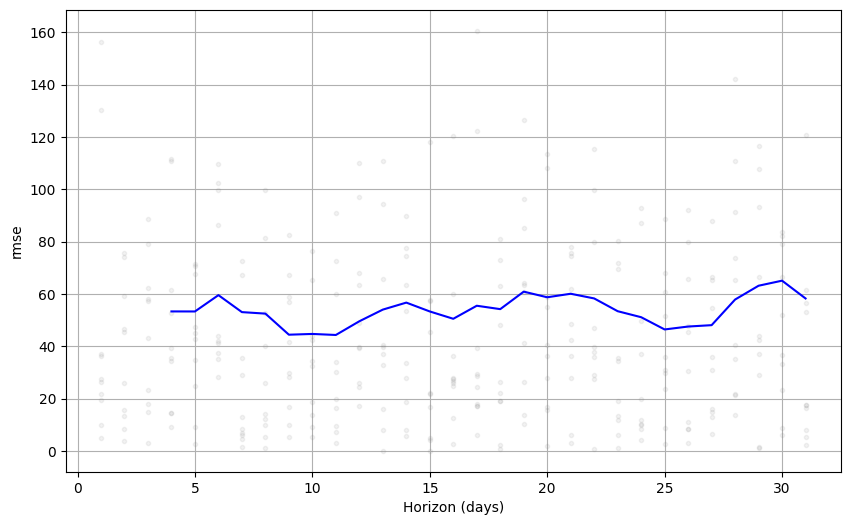

In [36]:
# Plotting
plot_cross_validation_metric(df_cv, metric='rmse');

Error seems fairly stable over time.

## Parameter Tuning

In [38]:
# Parameter Grid
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
              'seasonality_prior_scale': [1, 5, 10, 20],
              'holidays_prior_scale': [5, 10, 20, 25],
              'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(grid)

128

In [ ]:
# Tuning

# Storing variable
rmse = []

i = 1
# Loop
for params in grid:
  print(f'{i} / {len(grid)}')
  # Build model
  m = Prophet(holidays=holidays,
              seasonality_mode=params['seasonality_mode'],
              seasonality_prior_scale=params['seasonality_prior_scale'],
              holidays_prior_scale=params['holidays_prior_scale'],
              changepoint_prior_scale=params['changepoint_prior_scale'])
  m.add_regressor('Christmas')
  m.add_regressor('Temperature')
  m.add_regressor('Marketing')
  m.fit(df)

  # Cross-validation
  df_cv = cross_validation(model=m,
                           horizon='31 days',
                           period='16 days',
                           initial='2012 days',
                           parallel='processes')

  # Measure and store results
  error = performance_metrics(df_cv)['rmse'].mean()
  rmse.append(error)

  i += 1

In [43]:
# Check the results
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.005,5,additive,1,52.870553
1,0.005,5,additive,5,52.832279
2,0.005,5,additive,10,52.770940
3,0.005,5,additive,20,53.131043
4,0.005,5,multiplicative,1,50.964678
...,...,...,...,...,...
123,0.100,25,additive,20,49.522605
124,0.100,25,multiplicative,1,53.505620
125,0.100,25,multiplicative,5,53.339606
126,0.100,25,multiplicative,10,53.148500


In [45]:
# Export best parameters
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
best_params

,57
changepoint_prior_scale,0.01
holidays_prior_scale,25
seasonality_mode,additive
seasonality_prior_scale,5
rmse,48.042216


In [46]:
best_params.to_csv('../Forecasting-Product/best-params-prophet.csv')